## モジュールのimport

In [1]:
# Module
import sys
sys.path.append("../")
from mod.numpyro_utility import *

# DataFrame, Numerical computation
import polars as pl
pl.Config(fmt_str_lengths = 100, tbl_cols = 100, tbl_rows = 100)
import pandas as pd
import numpy as np
import jax
import jax.numpy as jnp
#import jax.random as random

# ベイズ推定
import numpyro
import numpyro.distributions as dist # 確率分布

# plot
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import arviz as az

# plotの設定
import json
def to_rc_dict(dict):
    """
    jsonファイルのdictを読み込む
    """
    return {f'{k1}.{k2}': v for k1,d in dict.items() for k2,v in d.items()}

file_path = "../mod/rcParams.json"
with open(file_path) as f: 
    plt.rcParams.update(to_rc_dict(json.load(f)))

# 日本語 or 英語の2択
import japanize_matplotlib
#plt.rcParams['font.family'] = "Times New Roman"

## 6.1 ABテストの効果検証

### 6.1.1 問題設定
> 鈴木さんと山田さんは、それぞれ自分の担当のWebページを持っており、担当頁に改善を加えました。\
> そして、回前後のページBと従来のページAをランダムに提示するABテストを実施し、効果検証をしました。\
> その結果が表6.1.1のとおりであった場合、2人それぞれの改善に効果があったかどうかを判断したいということがビジネス上の課題と考えてください。

_ | _ | 鈴木さん | 山田さん |
---- | ---- | ---- | ---- |
従来のページA | 表示数 | 40 | 1,200 |
_ | クリック数 | 2 | 60 |
_ | クリック率 | 5% | 5% |
改善後のページB | 表示数 | 25 | 1,500 |
_ | クリック数 | 2 | 110 |
_ | クリック率 | 8% | 6.88% |

### 6.1.2 確率モデル定義(鈴木さんの場合)
数式で整理してから、プログラミングで実装する。

1. クリック数は二項分布に従うと仮定する
    * $y_{a} \sim Bi(y|p_{a}, n_{a})$
    * $y_{b} \sim Bi(y|p_{b}, n_{b})$
1. クリック率 $p$ の事前分布は一様分布 $[0,1]$ に従うと仮定する。
1. Webページの改善効果はクリック率の変化ポイントで評価する。
    * $\Delta p \equiv p_{b} - p_{a}$

In [2]:
def model_ab_test(n_a, y_a, n_b, y_b):
    '''
        6.1節のABテストのモデル
    '''
    # 2. クリック率 $p$ の事前分布は一様分布 $[0,1]$ に従うと仮定する。
    p_a = numpyro.sample("p_a", dist.Uniform(low = 0, high = 1))
    p_b = numpyro.sample("p_b", dist.Uniform(low = 0, high = 1))
    # 1. クリック数は二項分布に従うと仮定する
    c_a = numpyro.sample("c_a", dist.Binomial(total_count = n_a, probs = p_a), obs = y_a)
    c_b = numpyro.sample("c_b", dist.Binomial(total_count = n_b, probs = p_b), obs = y_b)
    # 3. Webページの改善効果はクリック率の変化ポイントで評価する。
    Δp = numpyro.deterministic("Δp", p_b - p_a)

Model graph saved to: ABテストのモデル.svg


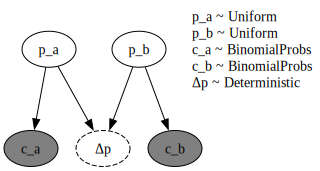

'ABテストのモデル.svg'

In [3]:
model_args = {
    "n_a": 40,
    "y_a": 2,
    "n_b": 25,
    "y_b": 2,
}
try_render_model(model_ab_test, render_name = "ABテストのモデル", **model_args)

### 6.1.3 サンプリングと結果分析

In [4]:
model_args = {
    "n_a": 40,
    "y_a": 2,
    "n_b": 25,
    "y_b": 2,
}
idata = run_mcmc(
    model_ab_test,
    num_chains = 4,
    num_warmup = 1000,
    num_samples = 1000,
    thinning = 1,
    seed = 42,
    target_accept_prob = 0.99,
    log_likelihood = False,
    **model_args
)

sample: 100%|██████████| 2000/2000 [00:00<00:00, 4480.32it/s, 7 steps of size 2.95e-01. acc. prob=0.99] 


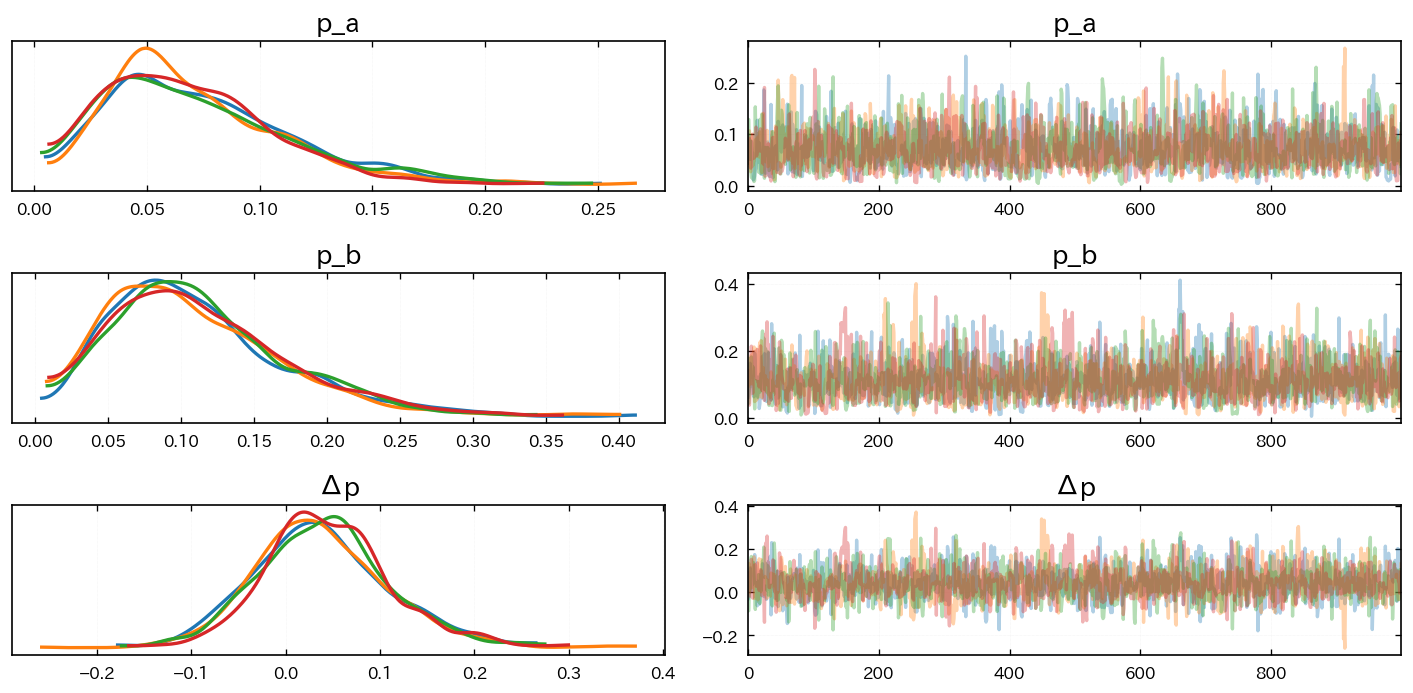

In [5]:
az.plot_trace(idata, compact = False, var_names = ["p_a", "p_b", "Δp"])
plt.tight_layout()

Text(0.5, 0.98, '鈴木さんのWebページのクリック率改善度合い')

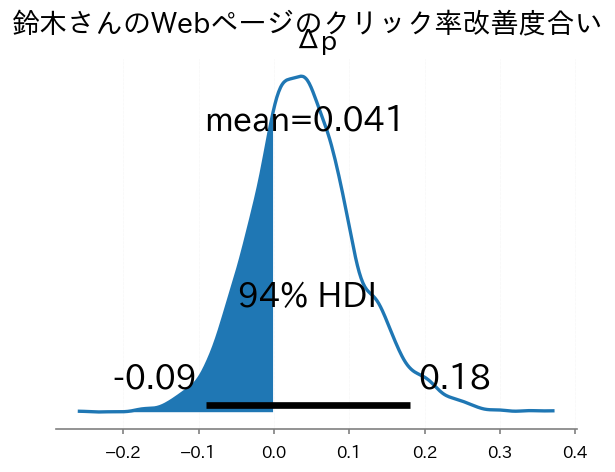

In [6]:
ax = az.plot_posterior(idata, var_names=["Δp"])
xx, yy = ax.get_lines()[0].get_data()
ax.fill_between(xx[xx<0], yy[xx<0]);
plt.suptitle("鈴木さんのWebページのクリック率改善度合い")

In [7]:
# サンプリング結果から　delta_probの値を抽出
delta_prob_s = idata['posterior'].data_vars['Δp']
delta_prob_s_values = delta_prob_s.values.reshape(-1)

# delta_probの値がマイナスであった件数
n1_s = (delta_prob_s_values < 0).sum()

# 全体サンプル数
n_s = len(delta_prob_s_values)

# 比率計算
n1_rate_s = n1_s/n_s
print(f'鈴木さんケース　画面Aの方がクリック率が高い確率: {n1_rate_s*100:.02f}%')

鈴木さんケース　画面Aの方がクリック率が高い確率: 28.18%


### 6.1.4 山田さんの場合

In [8]:
model_args = {
    "n_a": 1200,
    "y_a": 60,
    "n_b": 1500,
    "y_b": 110,
}
idata = run_mcmc(
    model_ab_test,
    num_chains = 4,
    num_warmup = 1000,
    num_samples = 1000,
    thinning = 1,
    seed = 42,
    target_accept_prob = 0.99,
    log_likelihood = False,
    **model_args
)

sample: 100%|██████████| 2000/2000 [00:00<00:00, 5078.07it/s, 7 steps of size 3.36e-01. acc. prob=0.99]


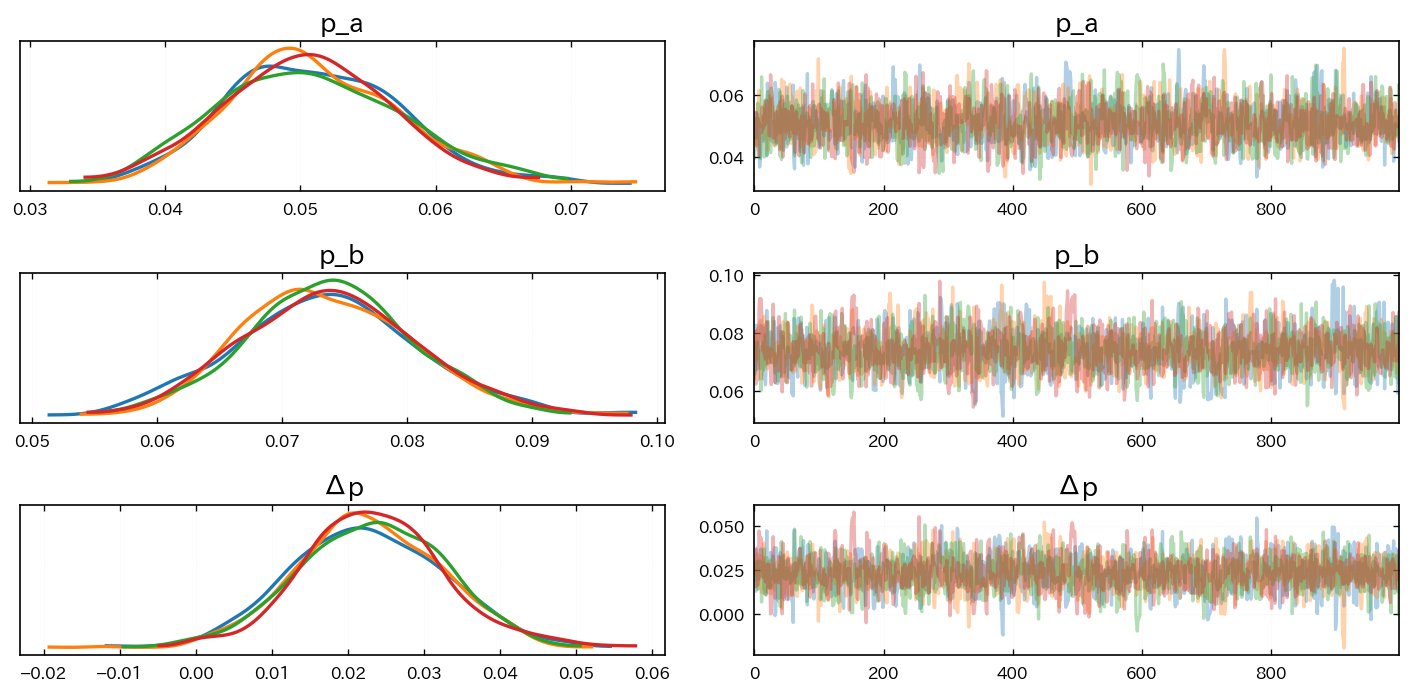

In [9]:
az.plot_trace(idata, compact = False, var_names = ["p_a", "p_b", "Δp"])
plt.tight_layout()

Text(0.5, 0.98, '山田さんのWebページのクリック率改善度合い')

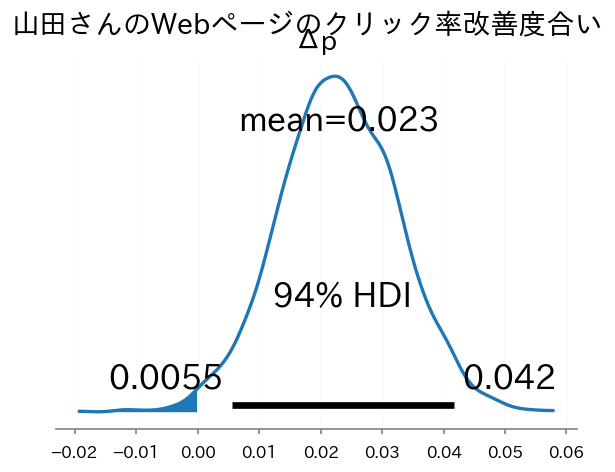

In [10]:
ax = az.plot_posterior(idata, var_names=["Δp"])
xx, yy = ax.get_lines()[0].get_data()
ax.fill_between(xx[xx<0], yy[xx<0]);
plt.suptitle("山田さんのWebページのクリック率改善度合い")

In [11]:
# サンプリング結果から　delta_probの値を抽出
delta_prob_s = idata['posterior'].data_vars['Δp']
delta_prob_s_values = delta_prob_s.values.reshape(-1)

# delta_probの値がマイナスであった件数
n1_s = (delta_prob_s_values < 0).sum()

# 全体サンプル数
n_s = len(delta_prob_s_values)

# 比率計算
n1_rate_s = n1_s/n_s
print(f'山田さんケース　画面Aの方がクリック率が高い確率: {n1_rate_s*100:.02f}%')

山田さんケース　画面Aの方がクリック率が高い確率: 0.75%


### 6.1.5 確率モデルを直接使った別解
省略